In [1]:
import sys
sys.path.append('../')
from xd import *
import numpy as np
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

#HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
#HFactor = HF(100, 10)

from systematics_module.corr import angular_correlation_poisson, angular_correlation

In [2]:
def NNpairCount(data, rand, weight_data = None, weight_rand = None, 
    nbins = 20, min_sep = 2.5/60., bin_slop=0.05, max_sep = 250/60., dir = './', suffix=''):
    # cmass and balrog : all systematic correction except obscuration should be applied before passing here
    
    import treecorr
    
    if weight_data : weight_data = data['WEIGHT']
    if weight_rand : weight_rand = rand['WEIGHT_RAND']

    cat = treecorr.Catalog(ra=data['RA'], dec=data['DEC'], w = weight_data, ra_units='deg', dec_units='deg')
    cat_rand = treecorr.Catalog(ra=rand['RA'], dec=rand['DEC'], is_rand=True, w = weight_rand, ra_units='deg', dec_units='deg')
    #nbins = 20
    #bin_size = 0.5
    #min_sep = 2.5/60.
    #max_sep = 250/60.
    sep_units = 'degree'

    dd = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    dr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    rr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    
    dd.process(cat)
    dr.process(cat,cat_rand)
    rr.process(cat_rand)
    
    dd.write(dir+'npairs'+suffix+'.txt', rr=rr, dr=dr)
    print 'file save to', dir+'npairs'+suffix+'.txt'
    #xi, varxi = dd.calculateXi(rr,dr)
    #errxi = np.sqrt(varxi)
    
    return dd, dr, rr

In [3]:
def BOSSveto(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

In [8]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix


from run_systematics import calling_sysMap
sysMap_fwhm = calling_sysMap( properties=['FWHM'], kind='SPT', nside=4096 )
fwhm_r_hpind = sysMap_fwhm['sys_FWHM_r_SPT']['PIXEL'][(sysMap_fwhm['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
fwhm_r_mask = np.in1d(GoldMask_spt['PIXEL'], fwhm_r_hpind)
SPTMaparea_sysmasked = GoldMask_spt[fwhm_r_mask].size * hp.nside2pixarea(4096, degrees=True)
print 'SPT area:', SPTMaparea
print 'after fwhm_r > 4.5 masked:', SPTMaparea_sysmasked


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz


KeyboardInterrupt: 

In [4]:
# import DMASS
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
#dmass = fitsio.read(rootdir+'spt.fits')
#dmass = io.SearchAndCallFits(path = rootdir, keyword='gold_spt_prob')
dmass = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
dmass = dmass[dmass['CMASS_PROB'] > 0.01]


dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB']*dmass['WEIGHT_SYS'])
print 'dmass sample size :', np.sum(dmass['WEIGHT'])
#dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])
#print np.sum(dmass['EachProb_CMASS']), np.sum(dmass_st82['EachProb_CMASS'])

rand_dmass = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt_masked')


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits
dmass sample size : 114774.39081275926

--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_masked.fits


In [67]:
hpind = hpRaDecToHEALPixel(dmass['RA'], dmass['DEC'], nside=4096)
fwhm_r_mask = np.in1d( hpind, fwhm_r_hpind)
print np.sum(dmass['WEIGHT'][fwhm_r_mask]), np.sum(dmass['WEIGHT'])

114774.39081275917 114774.39081275926


In [54]:
hprandind = hpRaDecToHEALPixel(rand_dmass['RA'], rand_dmass['DEC'], nside=4096)
fwhm_r_randmask = np.in1d( hprandind, fwhm_r_hpind)
print rand_dmass[fwhm_r_randmask].size, rand_dmass.size

20990512 20990512


In [4]:
#root = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/'
basedir = '../data_txt/cmass/'

In [4]:

#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]

cmasspath = '/n/des/lee.5922/data/cmass_cat/'
cmass_ngc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_North.fits.gz')
rand_ngc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_North.fits.gz')
cmass_sgc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_South.fits.gz')
rand_sgc = esutil.io.read([cmasspath+'random0_DR12v5_CMASS_South.fits.gz'
                          # ,cmasspath+'random1_DR12v5_CMASS_South.fits.gz'
                          ], combine=True)
#cmass_ngc = esutil.io.read(cmasspath+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc_reid = esutil.io.read(cmasspath+'cmass-dr12v4-S-Reid-full.dat.fits')

#cmass_sgc_zcut = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
#rand_sgc_zcut = rand_sgc[(rand_sgc['Z'] > 0.43) & (rand_sgc['Z'] < 0.7)]

In [6]:
cmass_weight = cmass_ngc['WEIGHT_SYSTOT']*(cmass_ngc['WEIGHT_CP']+cmass_ngc['WEIGHT_NOZ']-1.)
cmass_ngc = appendColumn(cat = cmass_ngc, name='WEIGHT', value=cmass_weight)
rand_ngc = appendColumn(cat = rand_ngc, name='WEIGHT_RAND', value=np.ones(rand_ngc['WEIGHT_FKP'].size))

In [7]:
cmass_weight = cmass_sgc['WEIGHT_SYSTOT']*(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.)
cmass_sgc = appendColumn(cat = cmass_sgc, name='WEIGHT', value=cmass_weight)
rand_sgc = appendColumn(cat = rand_sgc, name='WEIGHT_RAND', value=np.ones(rand_sgc['WEIGHT_FKP'].size))

In [42]:
cmass_zcut_weight = cmass_sgc_zcut['WEIGHT_FKP'] * cmass_sgc_zcut['WEIGHT_SYSTOT'] * (cmass_sgc_zcut['WEIGHT_CP']+cmass_sgc_zcut['WEIGHT_NOZ']-1.)
cmass_sgc_zcut = appendColumn(cat = cmass_sgc_zcut, name='WEIGHT', value=cmass_zcut_weight)
rand_sgc_zcut = appendColumn(cat = rand_sgc_zcut, name='WEIGHT_RAND', value=rand_sgc_zcut['WEIGHT_FKP'])

In [8]:
rand_sgc_veto = BOSSveto(rand_sgc, option='SGC')
cmass_sgc_veto = BOSSveto(cmass_sgc, option='SGC')

In [46]:
print np.sum((cmass_sgc_zcut['WEIGHT_CP']))
print np.sum((cmass_sgc_zcut['WEIGHT_CP']+cmass_sgc_zcut['WEIGHT_NOZ']-1.))
print np.sum(cmass_sgc_zcut['WEIGHT_SYSTOT'] *(cmass_sgc_zcut['WEIGHT_CP']+cmass_sgc_zcut['WEIGHT_NOZ']-1.))
print np.sum(cmass_sgc['WEIGHT_SYSTOT'] *(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.))

print np.sum(cmass_sgc_veto['WEIGHT_SYSTOT'] *(cmass_sgc_veto['WEIGHT_CP']+cmass_sgc_veto['WEIGHT_NOZ']-1.))

218590.0
222985.64
225469.03
249701.58
235153.31


In [130]:
print np.sum(cmass_ngc['WEIGHT_SYSTOT'] *(cmass_ngc['WEIGHT_CP']+cmass_ngc['WEIGHT_NOZ']-1.))

658792.5


In [64]:
Nsample = np.sum(cmass_sgc_veto['WEIGHT_SYSTOT'] *(cmass_sgc_veto['WEIGHT_CP']+cmass_sgc_veto['WEIGHT_NOZ']-1.))
TotalArea = 2422.648564262496 * 3600
Density_veto = Nsample*1./TotalArea
print 'veto area density:', Density_veto
Nsample = np.sum(cmass_sgc['WEIGHT_SYSTOT'] *(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.))
TotalArea = 2560 * 3600
Density = Nsample*1./TotalArea
print 'total area density:', Density

Nsample_dmass = np.sum(dmass['WEIGHT'])
TotalArea_SPT = 1235.61 * 3600
Density_dmass = Nsample_dmass/TotalArea_SPT
print 'dmass area density:', Density_dmass

veto area density: 0.02696237727043922
total area density: 0.02709435526529948
dmass area density: 0.026591292720770366


In [49]:
ddd, drd, rrd = NNpairCount(data = dmass, rand = rand_dmass, 
                    nbins=10, weight_data = True, weight_rand = None, 
                    suffix = '_DMASS_pcut_sysweight_10bins', dir = '../data_txt/cmass/')
print ddd.tot, drd.tot, rrd.tot

file save to ../data_txt/cmass/npairs_DMASS_pcut_sysweight_10bins.txt
6586580393.219998 2409173227647.913 2.20300797011e+14


In [ ]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, bin_slop=0.01, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_10bins_binslop_01', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, bin_slop=0.005, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_10bins_binslop_005', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_South_10bins_binslop_01.txt
31175440221.598083 2905590542035.3047 67701180303752.0


In [50]:
dd_veto, dr_veto, rr_veto = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_veto_10bins', dir = '../data_txt/cmass/')
print dd_veto.tot, dr_veto.tot, rr_veto.tot

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_South_veto_10bins.txt
27648537836.101913 2566387424018.2686 59554183743842.0


In [73]:
randind = np.random.choice(rand_sgc_veto.size, size = rand_sgc_veto.size/5)

In [32]:
dd, dr, rr = NNpairCount(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_veto_10bins', dir = '../data_txt/cmass/')

NameError: name 'cmass_sgc_veto' is not defined

In [ ]:
dd.tot, dr.tot, rr.tot

In [125]:
dd, dr, rr = NNpairCount(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=20, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_zcut_20bins', dir = '../data_txt/cmass/')

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_South_zcut_20bins.txt


In [178]:
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
tbins = np.logspace(np.log10(2.5/60), np.log10(250./60), 10 + 1)

DD_counts = DDtheta_mocks(1, 30, tbins, cmass_sgc_veto['RA'], cmass_sgc_veto['DEC'], output_thetaavg=True,
                          weights1 = cmass_sgc_veto['WEIGHT'], weight_type='pair_product', verbose=1)

gridlink_mocks_theta_ra_dec_double> Max. points in cell <= 764 ngrid (declination) = 22 max ngrid (ra) = 100. Number of points = 217452 Memory required = 5.8 MB. Time taken =   0.029 sec.
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.100% done. Time taken =  1.983 secs


In [7]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=20, bin_slop=0.05, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_20bins_binslop_05', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

dd, dr, rr = NNpairCount(data = cmass_ngc, rand = rand_ngc, 
                    nbins=20, bin_slop=0.05, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_North_20bins_binslop_05', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_South_20bins_binslop_05.txt
31175440221.598083 2905590542035.3047 67701180303752.0
file save to ../data_txt/cmass/npairs_DR12v5_CMASS_North_20bins_binslop_05.txt
217003728403.73517 21181323362067.188 516867224665540.5


In [9]:
dd, dr, rr = NNpairCount(data = cmass_sgc_veto , rand = rand_sgc_veto, 
                    nbins=20, bin_slop=0.05, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_veto_20bins_binslop_05', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

#dd, dr, rr = NNpairCount(data = cmass_ngc_veto, rand = rand_ngc_veto, 
#                    nbins=20, bin_slop=0.05, weight_data = True, weight_rand = True, 
#                    suffix = '_DR12v5_CMASS_North_20bins_binslop_05', dir = '../data_txt/cmass/')
#print dd.tot, dr.tot, rr.tot

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_South_veto_20bins_binslop_05.txt
27648537836.101913 2566387424018.2686 59554183743842.0


In [5]:
randind = np.random.choice(rand_dmass.size, size = rand_dmass.size/4)

In [7]:
dd, dr, rr = NNpairCount(data = dmass, rand = rand_dmass[randind], 
                    nbins=20, bin_slop=0.05, weight_data = True, weight_rand = None, 
                    suffix = '_dmass_pcut_sysweight_20bins_binslop_05', dir = '../data_txt/cmass/')
print dd.tot, dr.tot, rr.tot

file save to ../data_txt/cmass/npairs_dmass_pcut_sysweight_20bins_binslop_05.txt
6586580393.219998 602293306911.9783 1.37687998132e+13


In [9]:
randind = np.random.choice(rand_sgc_veto.size, size = rand_sgc_veto.size/10)

In [10]:
basedir = '../data_txt/cmass/corrftn/'
from systematics_module.corr import corrfunc_angular_correlation_single
corrftn_datatxt = \
corrfunc_angular_correlation_single(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                nbins = 10, weight = None, weight_rand = None, 
                suffix = 'DR12v5_CMASS_South', out = True, dir = basedir, nthreads=30)

calculate angular correlation function
load existing pickle file:  ../data_txt/cmass/corrftn//DR12v5_CMASS_South_dd.pkl


../systematics_module/corr.py:534: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if DD_counts == None :
/home/lee.5922/.local/lib/python2.7/site-packages/Corrfunc/mocks/DDtheta_mocks.py:288: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warn('One or more input array has non-native endianness!  A copy will be made with the correct endianness.')
gridlink_mocks_theta_ra_dec_double> Max. points in cell <= 764 ngrid (declination) = 22 max ngrid (ra) = 100. Number of points = 217452 Memory required = 5.8 MB. Time taken =   0.029 sec.
gridlink_mocks_theta_ra_dec_double> Max. points in cell <= 30317 ngrid (declination) = 22 max ngrid (ra) = 100. Number of points = 10913678 Memory required = 2.8e+02 MB. Time taken =   2.875 sec.
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.

../data_txt/cmass/corrftn//DR12v5_CMASS_South_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn//corrfunc_acf_auto_single_DR12v5_CMASS_South.txt


100% done. Time taken =     3 mins   17 secs


In [11]:
thetaavg, wtheta, sigma = corrftn_datatxt[:,0], corrftn_datatxt[:,1], corrftn_datatxt[:,2]

In [15]:
thetaavg, wtheta

(array([0.05468098, 0.08665236, 0.13736908, 0.21776295, 0.34533225,
        0.54708083, 0.86725684, 1.37438864, 2.17759812, 3.44939162]),
 array([0.18317743, 0.13348541, 0.09755241, 0.06908929, 0.04737364,
        0.03124527, 0.01921406, 0.01113338, 0.00589309, 0.00274336]))

(0.041666666666666664, 4.166666666666667)

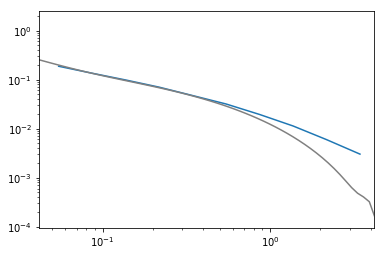

In [12]:
theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)



fig, ax = plt.subplots()
ax.loglog( thetaavg, wtheta )
ax.plot(theta_th, theory, '-', color='grey', label='theory')

ax.set_xlim(2.5/60, 250./60)


In [62]:
angular_correlation_poisson(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_North', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_North.txt


In [78]:
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR11v1_CMASS_South', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR11v1_CMASS_South_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR11v1_CMASS_South.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR11v1_CMASS_South_zcut.txt


In [27]:
#os.system('rm ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South.txt')
#os.system('rm ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt')

random_ind = np.random.choice( rand_sgc.size, size = rand_sgc.size/10)
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc[random_ind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_ran10', dir = basedir)

random_ind = np.random.choice( rand_sgc.size, size = rand_sgc.size/5)
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc[random_ind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_ran5', dir = basedir)

angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran10.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran5.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt


In [43]:
angular_correlation_poisson(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_veto', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_veto.txt


In [27]:
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass-dr12v4-S-Reid-full', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass-dr12v4-S-Reid-full_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full_zcut.txt


In [7]:
basedir

'../data_txt/cmass/'

In [ ]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, bin_slop=0.05, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_bins10_binslop05_jk100', dir = basedir)

calculate angular correlation function
generate new jkregion : ../data_txt/cmass/./jkregion.txt
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [ 7  7  5 10 13  5  8  4 10 15 10  8 13  9 12  7  6 10 14  9 14 10 18 11
  4  4 16 13 12 12 13 11  5  6  7  8 16  5  4 16  8  5 13  4  5  3 11 12
  5 12 19  4  4 13  6  7 12 16  7 15 19  8  0  6 12 13  8 13  7  8 10 12
 19 11 15 15 14 15 11 18 13  9 16  3 15  4 16 10 13  4  6  5 10 12 11 10
 15 13  6  7]
X (230831, 2)  centers (100, 2)  tol=1e-05  maxiter=200
124 iterations  cluster sizes: [1886 2601 2145 2272 2812 1866 2470 2478 2848 2701 2042 2449 2412 2585
 2528 2455 1687 2221 2788 1505 2468 2401 2564 2228 1861 1691 2731 2622
 2448 1999 2601 2700 2324 2540 1939 2358 2120 2111 2247 2019 2218 1681
 2406 2075 2621 1485 2594 2052 2109 2337 3085 2348 1609 2515 2380 2308
 2758 2748 2225 2318 2203 2343 1760 2411 2859 2216 1292 2546 2424 2568
 2429 2403 1961 2643 2271 2548 1992 2268 2732 1912 2373 2408 2366 1995
 

In [80]:
angular_correlation(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_zcut_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [ 5 13 18 10  3  7 11 12  6 10  6 18  5  8  6 20 12  7  9  2 11  7 23  9
  5 11 14  8 11 11  6  9 11 12  8  9  5 13 12  6  5  9  8  3 12  8  9 12
 14  6 19 17 18 15  6  9  6  8  6 23 11  6  5  7  7 17  9 10  9  7 15  9
  5 12 14 13  6  6  0  8 16 14  5 21  5  7  9 11  8 11 12 12  8 20 11 17
  7  8 12  8]
X (208426, 2)  centers (100, 2)  tol=1e-05  maxiter=200
140 iterations  cluster sizes: [2104 2410 2355 1594 1948 1804 2589 1644 1790 2544 2077 2217 1608 2286
 2165 1945 2108 1688 2109 1984 2262 2169 3112 1896 1918 2300 1962 1945
 1629 2265 1960 2117 2432 2400 2112 2249 1903 2123 2363 2007 2062 1741
 2276 2408 2117 1689 2175 2394 2180 2025 2391 2370 2450 2060 2286 1662
 1514 1909 1676 2022 2063 1911 2241 2176 2055 1998 2338 2603 2237 2280
 1582 2041 2034 2546 2033 2283 2283 2093 1841 1395 2132 1767 2279 2084
 2022 2026 1479 2067 1772 1639 2021 2654 2229 2258 2232 23

In [30]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 50, 
                    suffix = '_DR12v5_CMASS_South_jk50', dir = basedir)

calculate angular correlation function
X (960, 2)  centers (50, 2)  tol=1e-05  maxiter=200
24 iterations  cluster sizes: [10 13 25 13 22 14 18 12 31 21 16 19 21 11 21 12 11 18 14 15 28 12 24 19
 38 15 24 19 20 26 19 16 23 33 23 25 13 13 19 15 18 24 25 15 22 16 19 16
 26 18]
X (230831, 2)  centers (50, 2)  tol=1e-05  maxiter=200
65 iterations  cluster sizes: [3916 4920 4632 3855 4061 4782 4324 4374 3967 4305 3982 4756 4985 4133
 5408 4010 3568 4943 4497 4467 6043 4377 5503 4248 5729 5115 4872 5606
 4816 5074 4630 5009 5693 5580 5270 3723 2990 4572 4531 4205 3950 4398
 5375 5039 4565 5150 4520 3940 4555 3868]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/cmass//acf_auto_DR12v5_CMASS_South_jk50.txt


In [86]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 20, 
                    suffix = '_DR12v5_CMASS_South_jk20', dir = basedir)

calculate angular correlation function
X (960, 2)  centers (20, 2)  tol=1e-05  maxiter=200
32 iterations  cluster sizes: [50 50 41 32 33 50 36 59 47 58 63 45 31 60 64 31 48 71 48 43]
X (230831, 2)  centers (20, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [11002 11318 11954 11015 11867 14400  9708 10743 12963 10431 10870 11948
 11498 11660 12194 10907 11065 13348 10767 11173]
. . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/mocks//acf_auto_DR12v5_CMASS_South_jk20.txt


In [ ]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_jk100', dir = basedir)

angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 150, 
                    suffix = '_DR12v5_CMASS_South_jk150', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
22 iterations  cluster sizes: [ 6 12 10 12  7 12  9 13  5  8 10 11  9 11 17  9  9 22  6  8 10  5 10 12
  8 10  6 14  8  9 12 11 18  1 11 12  5  9  8 10  2  7 22  5  9  6  8 16
  8 15 19 11 11 10  5  5  7 14 10 17  4 17 11 17  9 15 10  7 11 12 11  3
 10 10 13 12  1  6  8  5 15 11  9  9  9 11  6  7 12  8  4 14 12 13 11 10
 13 15  8  9]
X (230831, 2)  centers (100, 2)  tol=1e-05  maxiter=200
132 iterations  cluster sizes: [2471 2069 2109 2188 2393 2544 2603 2398 2646 2470 2423 2409 2546 2188
 2521 1999 1841 2127 2188 2268 2864 1805 1634 2656 2422 2122 1685 2409
 1785 2038 2322 2295 2676 2126 2599 2678 1911 2591 2270 2258 2358 2227
 2416 2380 2488 1824 2278 2751 2059 2012 2330 1942 2322 2455 1705 2073
 1717 2413 3126 2164 1905 2680 2195 2544 2810 1953 3002 2778 1897 2409
 2799 2297 2051 2310 2345 2585 2064 2121 2092 2335 2547 2490 2385 2578
 2175 1920 1771 2877 2237 2687 2759 2436 2462 2645 2185 21

In [100]:
rand_sgc_veto = BOSSveto(rand_sgc, option='SGC')
randind = np.random.choice( rand_sgc_veto.size, size = rand_sgc_veto.size/10)

cmass_sgc_veto = BOSSveto(cmass_sgc, option='SGC')

angular_correlation(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight = [True, True], njack = 200, 
                    suffix = '_DR12v5_CMASS_South_veto_jk200', dir = basedir)

calculate angular correlation function
X (2000, 2)  centers (200, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [ 4  8  3  9 13  5 12 12  6  9 11  7  2 14 15 11 10 18 10 13  6  4 17  8
 10 17 12 12  4  4  7 10 16  8 12 10  6  8  6 10  6  9  7 10  9 27  5 12
  6  5 13  6  4  4 15 11  9 21  9  8  9 21 11  7  8 11 13 15  6  7  7 13
 12 15 11  8  4  5 15  8 12  7  8  8 15 10 11 21  9  9  6  4  7 18 11  2
 12  6 14  4  8  7  4 12  9  3 13  2 12  4 11 12 19 10 22 10  6  9 12 13
 12  5  7  5  9 19  0 11 12  4 10 21 10  8  8  6 18  3 12 13 12  7  5  7
 16 14  7 10 17 10  6 11 10  9 10 12 13 10 17  8  9 11 16  7 19  9 16  6
  9 10 14 11  4  4  7  7  8 11  3  8 17  2 17 20 10  4  6  8 11 21 13 22
 13 14  6  1 14  2 15 18]
X (217452, 2)  centers (200, 2)  tol=1e-05  maxiter=200
102 iterations  cluster sizes: [1083 1064  881  986 1007 1054 1334 1164  918 1307 1136 1038 1244  863
 1160 1199  885 1139 1138 1125 1021 1311  952 1020 1038 1327 1185  975
 1075  952  844 1084 1016 1047 1021 11

In [68]:
#path = '/n/des/lee.5922/data/cmass_cat/patchy_mock/'
#cmass_mock_rand_file_S = np.loadtxt(path+'Random-DR12CMASS-S-V6C-x10.dat')

In [5]:
#cmass_mock_rand_file = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_N_50x1.rdzw')
cmass_mock_rand_file = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x1.rdzw')
#cmass_mock_rand_file2 = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x2.rdzw')
#cmass_mock_rand_file3 = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_LOWZ_S_50x1.rdzw')
#cmass_mock_rand_file4 = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_LOWZ_S_50x2.rdzw')

In [14]:

#cmass_mock_rand_file = np.loadtxt(path+'Random-DR12CMASS-N-V6C-x10.dat')
random_mock = np.zeros( (cmass_mock_rand_file.shape[0],), 
    dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT_RAND', 'float')])
random_mock['RA'] = cmass_mock_rand_file[:,0]
random_mock['DEC'] = cmass_mock_rand_file[:,1]
random_mock['Z'] = cmass_mock_rand_file[:,2]
random_mock['WEIGHT_FKP'] = cmass_mock_rand_file[:,3]
#random_mock['WEIGHT_VETO'] = cmass_mock_rand_file[:,4]
random_mock['WEIGHT_RAND'] = cmass_mock_rand_file[:,3] # * random_mock['WEIGHT_VETO']
random_mock = BOSSveto(random_mock, option='SGC')

#random_mock = random_mock[(random_mock['Z'] > 0.43) & (random_mock['Z'] < 0.7)]
#cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
#random_mock = random_mock[ random_mock['VETO_FLAG'] == 1]

figsave : .//spatialtest_.png


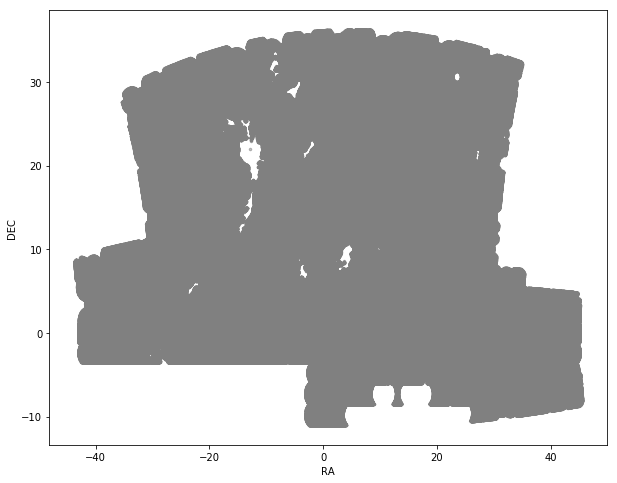

In [15]:
spatialcheck([random_mock])

In [16]:
#fitsio.write('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x1.fits', random_mock)

In [17]:
#cmass_mock_rand_file = None

In [11]:
random_mock = esutil.io.read('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x1.fits')
#random_mock = esutil.io.read('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_N_50x1.fits')

In [ ]:
#basedir =  '../data_txt/mocks_bin20/'
#os.system('mkdir '+basedir)
from systematics_module.corr import corrfunc_angular_correlation_single
#basedir1 = '../data_txt/cmass/NGC_ran10/'
basedir1 = '../data_txt/cmass/SGC_20bins_binslop1/'
#basedir2 = '../data_txt/cmass/corrftn_mocks_less_ran/'
os.system('mkdir '+basedir1)   
#os.system('mkdir '+basedir2)   
    
#randind = np.random.choice(random_mock.size, size = random_mock.size/10)

for i in range(1, 252):
    try : 
        path = '/n/des/lee.5922/data/cmass_cat/qpm_mocks/'
        name = 'mock_galaxy_DR12_CMASS_S_QPM_{:04}.rdzw'.format(i)
        #print path+name
        
        #path = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C/'
        #name = 'Patchy-Mocks-DR12SGC-COMPSAM_V6C_{:04}.dat'.format(i)
        cmass_mock_file = np.loadtxt(path+name)

        #cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
        cmass_mock = np.zeros( (cmass_mock_file.shape[0],), 
            dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT', 'float')])
        cmass_mock['RA'] = cmass_mock_file[:,0]
        cmass_mock['DEC'] = cmass_mock_file[:,1]
        cmass_mock['Z'] = cmass_mock_file[:,2]
        cmass_mock['WEIGHT_FKP'] = cmass_mock_file[:,3]
        cmass_mock['WEIGHT_VETO'] = cmass_mock_file[:,4]
        #cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
        cmass_mock['WEIGHT'] = cmass_mock_file[:,4] *cmass_mock_file[:,3]
        #cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
        cmass_mock = BOSSveto(cmass_mock, option='SGC')
        
        #corrfunc_angular_correlation_single(data = cmass_mock, rand = random_mock[randind], 
        #        nbins = 10, weight = None, weight_rand = None, 
        #        suffix = name, dir = basedir2, nthreads=30, verbose=0)
        
        angular_correlation_poisson(data = cmass_mock, rand = random_mock, 
                                    nbins=20, bin_slop=0.1, weight_data = True, weight_rand = True, 
                                    suffix = '_'+name, dir = basedir1)
        
    except (IOError, ValueError): 
        print i, 'no files'
        pass

saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0252.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0253.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0254.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0255.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0256.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0257.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0258.rdzw.txt
saving data file to :  ../data_txt/cmass/SGC_20bins_binslop1//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0259.rdzw.txt
saving data file to :  .

In [112]:
#basedir =  '../data_txt/mocks_bin20/'
#os.system('mkdir '+basedir)
random_mock = random_mock[ random_mock['RA'] < 38 ]
from systematics_module.corr import corrfunc_angular_correlation_single
basedir1 = '../data_txt/cmass/mocks_halfA/'
#basedir2 = '../data_txt/cmass/corrftn_mocks_less_ran/'
os.system('mkdir '+basedir1)   
#os.system('mkdir '+basedir2)   
    
    
random_mock = random_mock[ random_mock['RA'] < 38 ]
#randind = np.random.choice(random_mock.size, size = random_mock.size/10)

for i in range(1, 1001):
    try : 
        path = '/n/des/lee.5922/data/cmass_cat/qpm_mocks/'
        name = 'mock_galaxy_DR12_CMASS_S_QPM_{:04}.rdzw'.format(i)
        #print path+name
        
        #path = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C/'
        #name = 'Patchy-Mocks-DR12SGC-COMPSAM_V6C_{:04}.dat'.format(i)
        cmass_mock_file = np.loadtxt(path+name)

        #cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
        cmass_mock = np.zeros( (cmass_mock_file.shape[0],), 
            dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT', 'float')])
        cmass_mock['RA'] = cmass_mock_file[:,0]
        cmass_mock['DEC'] = cmass_mock_file[:,1]
        cmass_mock['Z'] = cmass_mock_file[:,2]
        cmass_mock['WEIGHT_FKP'] = cmass_mock_file[:,3]
        cmass_mock['WEIGHT_VETO'] = cmass_mock_file[:,4]
        #cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
        cmass_mock['WEIGHT'] = cmass_mock_file[:,4] *cmass_mock_file[:,3]
        #cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
        cmass_mock = BOSSveto(cmass_mock, option='SGC')
        #ramask = [cmass_sgc_veto['RA'] < 38 ]
        cmass_mock = cmass_mock[cmass_mock['RA'] < 38 ]
        
        #corrfunc_angular_correlation_single(data = cmass_mock, rand = random_mock[randind], 
        #        nbins = 10, weight = None, weight_rand = None, 
        #        suffix = name, dir = basedir2, nthreads=30, verbose=0)
        
        angular_correlation_poisson(data = cmass_mock, rand = random_mock, 
                                    nbins=10, weight_data = True, weight_rand = True, 
                                    suffix = '_'+name, dir = basedir1)
        
    except (IOError, ValueError): 
        print i, 'no files'
        pass

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0002.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0003.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0004.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0005.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0006.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0007.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0008.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0078.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0079.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0080.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0081.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0082.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0083.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0084.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0085.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0150.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0151.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0152.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0153.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0154.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0155.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0156.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0157.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0222.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0223.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0224.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0225.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0226.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0227.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0228.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0229.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0294.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0295.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0296.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0297.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0298.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0299.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0300.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0301.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0366.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0367.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0368.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0369.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0370.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0371.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0372.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0373.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0438.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0439.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0440.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0441.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0442.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0443.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0444.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0445.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0510.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0511.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0512.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0513.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0514.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0515.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0516.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0517.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0582.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0583.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0584.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0585.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0586.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0587.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0588.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0589.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0654.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0655.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0656.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0657.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0658.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0659.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0660.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0661.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0726.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0727.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0728.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0729.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0730.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0731.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0732.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0733.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0798.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0799.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0800.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0801.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0802.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0803.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0804.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0805.rdzw.txt
saving data file to :  ../data_txt/cmass/mocks_halfA//acf_auto_poisson_mock_galaxy_DR12_

KeyboardInterrupt: 

In [10]:
path = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C/'
name = 'Patchy-Mocks-DR12SGC-COMPSAM_V6C_{:04}.dat'.format(1)
cmass_mock_file = np.loadtxt(path+name)

In [31]:

cz = cmass_mock_file[:,2]

czmask =  cz > 0.43 

cz_masked = cz[czmask]
cbias = cmass_mock_file[:,5][czmask]

In [34]:
cbias

array([1.84382, 1.99084, 1.89085, ..., 1.93976, 2.27251, 1.87391])

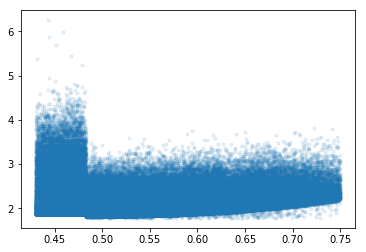

In [35]:
fig, ax = plt.subplots()
ax.plot(cz_masked, cbias, '.', alpha=0.1)

In [ ]:
# RA, DEC, Z, MSTAR, NBAR, BIAS, VETO FLAG, FIBER COLLISION

In [25]:
cmass_mock_rand_file = np.loadtxt('/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C_x10.dat')

random_mock = np.zeros( (cmass_mock_rand_file.shape[0],), 
    dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_CP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT_RAND', 'float')])
random_mock['RA'] = cmass_mock_rand_file[:,0]
random_mock['DEC'] = cmass_mock_rand_file[:,1]
random_mock['Z'] = cmass_mock_rand_file[:,2]
random_mock['WEIGHT_VETO'] = cmass_mock_rand_file[:,5]
random_mock['WEIGHT_CP'] = cmass_mock_rand_file[:,6]
random_mock['WEIGHT_RAND'] = random_mock['WEIGHT_CP'] * random_mock['WEIGHT_VETO']

random_mock = random_mock[ random_mock['Z'] >0.43 ]
#random_mock = BOSSveto(random_mock, option='SGC')

In [26]:
#basedir =  '../data_txt/mocks_bin20/'
#os.system('mkdir '+basedir)

from systematics_module.corr import corrfunc_angular_correlation_single
basedir1 = '../data_txt/cmass/mocks_mdpatch/'
#basedir2 = '../data_txt/cmass/corrftn_mdpatch/'
os.system('mkdir '+basedir1)   
#os.system('mkdir '+basedir2)   
    
    
randind = np.random.choice(random_mock.size, size = random_mock.size/10)

for i in range(10, 2001):
    try : 
        #path = '/n/des/lee.5922/data/cmass_cat/qpm_mocks/'
        #name = 'mock_galaxy_DR12_CMASS_S_QPM_{:04}.rdzw'.format(i)
        #print path+name
        
        path = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12SGC-COMPSAM_V6C/'
        name = 'Patchy-Mocks-DR12SGC-COMPSAM_V6C_{:04}.dat'.format(i)
        cmass_mock_file = np.loadtxt(path+name)

        #cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
        
        # RA, DEC, Z, MSTAR, NBAR, BIAS, VETO FLAG, FIBER COLLISION
        cmass_mock = np.zeros( (cmass_mock_file.shape[0],), 
            dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('VETO_FLAG', 'int'), ('WEIGHT_CP', 'int'), ('WEIGHT', 'float')])
        cmass_mock['RA'] = cmass_mock_file[:,0]
        cmass_mock['DEC'] = cmass_mock_file[:,1]
        cmass_mock['Z'] = cmass_mock_file[:,2]
        #cmass_mock['MSTAR'] = cmass_mock_file[:,3]
        #cmass_mock['NBAR'] = cmass_mock_file[:,4]
        #cmass_mock['BIAS'] = cmass_mock_file[:,5]
        cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
        cmass_mock['WEIGHT_CP'] = cmass_mock_file[:,7]
        cmass_mock['WEIGHT'] = cmass_mock['VETO_FLAG'] * cmass_mock['WEIGHT_CP']
        cmass_mock = cmass_mock[ cmass_mock['Z'] > 0.43 ]
        
        #cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
        #cmass_mock = BOSSveto(cmass_mock, option='SGC')    
        
        #corrfunc_angular_correlation_single(data = cmass_mock, rand = random_mock, 
        #        nbins = 10, weight = None, weight_rand = None, 
        #        suffix = name, dir = basedir2, nthreads=30, verbose=0)
        
        angular_correlation_poisson(data = cmass_mock, rand = random_mock, 
                                    nbins=10, weight_data = True, weight_rand = True, 
                                    suffix = '_'+name, dir = basedir1)
        
    except (IOError, ValueError): 
        print i, 'no files'
        pass

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0010.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0011.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0012.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0013.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0021.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0022.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0023.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0024.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0086.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0087.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0088.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0089.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0090.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0091.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0092.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0093.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0155.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0156.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0157.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0158.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0159.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0160.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0161.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0162.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0224.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0225.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0226.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0227.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0228.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0229.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0230.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0231.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0293.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0294.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0295.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0296.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0297.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0298.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0299.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0300.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0362.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0363.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0364.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0365.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0366.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0367.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0368.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0369.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0431.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0432.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0433.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0434.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0435.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0436.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0437.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0438.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0500.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0501.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0502.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0503.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0504.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0505.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0506.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0507.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0569.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0570.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0571.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0572.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0573.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0574.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0575.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0576.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0638.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0639.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0640.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0641.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0642.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0643.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0644.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0645.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0707.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0708.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0709.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0710.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0711.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0712.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0713.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0714.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0776.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0777.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0778.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0779.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0780.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0781.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0782.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0783.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0845.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0846.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0847.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0848.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0849.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0850.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0851.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0852.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0914.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0915.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0916.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0917.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0918.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0919.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0920.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0921.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0983.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0984.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0985.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0986.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0987.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0988.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0989.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0990.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1052.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1053.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1054.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1055.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1056.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1057.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1058.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1059.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1121.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1122.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1123.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1124.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1125.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1126.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1127.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1128.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1190.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1191.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1192.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1193.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1194.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1195.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1196.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1197.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1259.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1260.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1261.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1262.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1263.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1264.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1265.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1266.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1328.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1329.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1330.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1331.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1332.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1333.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1334.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1335.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1397.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1398.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1399.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1400.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1401.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1402.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1403.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1404.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1466.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1467.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1468.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1469.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1470.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1471.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1472.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1473.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1535.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1536.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1537.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1538.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1539.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1540.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1541.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1542.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1604.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1605.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1606.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1607.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1608.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1609.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1610.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1611.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1673.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1674.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1675.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1676.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1677.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1678.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1679.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1680.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1742.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1743.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1744.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1745.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1746.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1747.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1748.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1749.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1811.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1812.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1813.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1814.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1815.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1816.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1817.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1818.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1880.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1881.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1882.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1883.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1884.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1885.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1886.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1887.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1949.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1950.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1951.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1952.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1953.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1954.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1955.dat.txt
saving data file to :  ../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_1956.dat.txt
saving data file to :  ../data_txt/cmass/mocks_m

calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0001_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0001_dr.pkl
../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0001.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0002_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0002_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0002.txt


../systematics_module/corr.py:534: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if DD_counts == None :


saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0002.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0003_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0003_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0003.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0003.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0004_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0004_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0018_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0018.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0018.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0019_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0019_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0019.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0019.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0033.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0034_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0034_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0034.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0034.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0035_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0035_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0049_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0049.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0049.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0050_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0050_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0050.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0050.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0064.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0065_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0065_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0065.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0065.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0066_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0066_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0080_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0080.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0080.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0081_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0081_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0081.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0081.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0095.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0096_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0096_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0096.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0096.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0097_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0097_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0111_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0111.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0111.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0112_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0112_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0112.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0112.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0126.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0127_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0127_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0127.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0127.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0128_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0128_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0142_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0142.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0142.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0143_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0143_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0143.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0143.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0157.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0158_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0158_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0158.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0158.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0159_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0159_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0173_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0173.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0173.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0174_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0174_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0174.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0174.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0188.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0189_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0189_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0189.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0189.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0190_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0190_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0204_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0204.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0204.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0205_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0205_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0205.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0205.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0219.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0220_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0220_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0220.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0220.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0221_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0221_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0235_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0235.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0235.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0236_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0236_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0236.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0236.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0250.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0251_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0251_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0251.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0251.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0252_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0252_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0266_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0266.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0266.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0267_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0267_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0267.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0267.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0281.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0282_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0282_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0282.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0282.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0283_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0283_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0297_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0297.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0297.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0298_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0298_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0298.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0298.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0312.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0313_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0313_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0313.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0313.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0314_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0314_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0332_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0332_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0332.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0332.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0333_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0333_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0333.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_D

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0347.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0348_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0348_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0348.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0348.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0349_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0349_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0363_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0363.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0363.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0364_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0364_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0364.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0364.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0378.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0379_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0379_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0379.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0379.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0380_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0380_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0394_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0394.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0394.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0395_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0395_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0395.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0395.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0409.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0410_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0410_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0410.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0410.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0411_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0411_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0425_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0425.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0425.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0426_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0426_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0426.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0426.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0440.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0441_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0441_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0441.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0441.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0442_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0442_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0456_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0456.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0456.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0457_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0457_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0457.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0457.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0471.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0472_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0472_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0472.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0472.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0473_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0473_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0487_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0487.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0487.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0488_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0488_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0488.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0488.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0502.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0503_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0503_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0503.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0503.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0504_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0504_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0518_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0518.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0518.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0519_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0519_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0519.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0519.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0533.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0534_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0534_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0534.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0534.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0535_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0535_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0549_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0549.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0549.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0550_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0550_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0550.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0550.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0564.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0565_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0565_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0565.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0565.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0566_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0566_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0580_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0580.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0580.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0581_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0581_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0581.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0581.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0595.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0596_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0596_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0596.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0596.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0597_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0597_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0611_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0611.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0611.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0612_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0612_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0612.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0612.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0626.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0627_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0627_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0627.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0627.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0628_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0628_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0642_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0642.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0642.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0643_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0643_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0643.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0643.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0657.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0658_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0658_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0658.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0658.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0659_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0659_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0673_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0673.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0673.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0674_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0674_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0674.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0674.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0688.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0689_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0689_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0689.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0689.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0690_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0690_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0704_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0704.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0704.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0705_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0705_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0705.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0705.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0719.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0720_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0720_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0720.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0720.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0721_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0721_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0735_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0735.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0735.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0736_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0736_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0736.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0736.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0750.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0751_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0751_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0751.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0751.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0752_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0752_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0766_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0766.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0766.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0767_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0767_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0767.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0767.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0781.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0782_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0782_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0782.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0782.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0783_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0783_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0797_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0797.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0797.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0798_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0798_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0798.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0798.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0812.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0813_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0813_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0813.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0813.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0814_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0814_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0828_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0828.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0828.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0829_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0829_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0829.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0829.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0843.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0844_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0844_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0844.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0844.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0845_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0845_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0859_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0859.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0859.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0860_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0860_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0860.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0860.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0874.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0875_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0875_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0875.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0875.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0876_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0876_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0890_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0890.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0890.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0891_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0891_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0891.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0891.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0905.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0906_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0906_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0906.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0906.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0907_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0907_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0921_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0921.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0921.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0922_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0922_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0922.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0922.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0936.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0937_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0937_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0937.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0937.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0938_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0938_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0952_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0952.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0952.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0953_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0953_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0953.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0953.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0967.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0968_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0968_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0968.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0968.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0969_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0969_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0983_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0983.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0983.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0984_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0984_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0984.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0984.txt
calculate angular correlation function
../data_txt/cmass/c

saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0998.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0999_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_0999_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran//corrfunc_acf_auto_single_mock_galaxy_DR12_CMASS_S_QPM_0999.txt
saving data file to :  ../data_txt/cmass/mocks_no_weight_less_ran//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0999.txt
calculate angular correlation function
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_1000_dd.pkl
../data_txt/cmass/corrftn_mocks_less_ran//mock_galaxy_DR12_CMASS_S_QPM_1000_dr.pkl
load existing pickle file:  ../data_txt/cmass/corrftn_mocks_less_ran//RR.pkl
saving data file to :  ../data_txt/cmass/corrftn_mocks_less_ran/

In [18]:
xi_list = []
for i in range(1,201):
    try:
        meanr, xi, _ = np.loadtxt('../data_txt/mocks_ran10//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_{:04}.txt'.format(i), unpack=True)
        #ax.errorbar(meanr, xi, yerr = xi_err, fmt = '-', color='r', alpha = 0.5)
        xi_list.append(xi)
    except (IOError, ValueError): pass
    
xi_list = np.array(xi_list)
xi_list_mean = np.mean(xi_list, axis=0)
xi_list_sigma = np.std(xi_list, axis=0)

In [ ]:
#RA, DEC, Z, MSTAR, NBAR, BIAS, VETO FLAG, FIBER COLLISION

In [ ]:
meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/cmass/acf_auto_poisson_DR12v5_CMASS_South.', unpack=True)

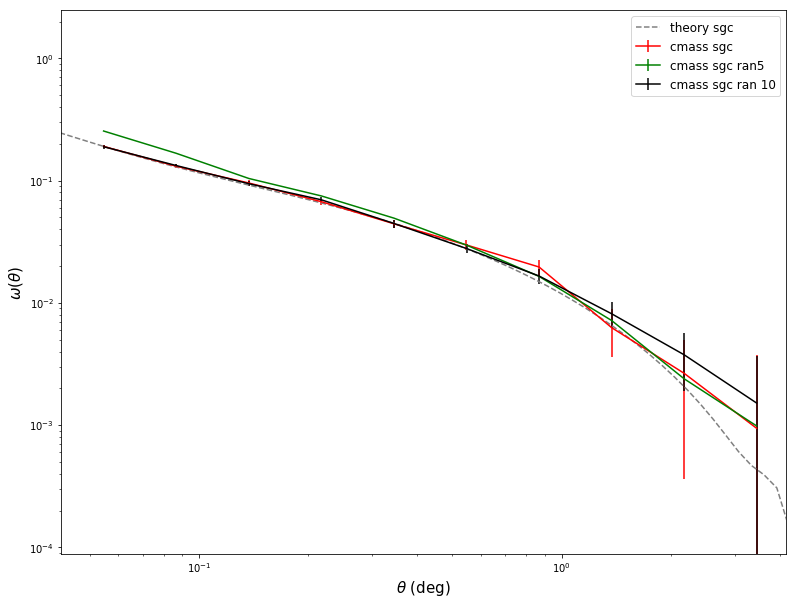

In [36]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran10.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran5.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass/mocks_mdpatch//acf_auto_poisson_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0001.dat.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass/corrftn_mdpatch//corrfunc_acf_auto_single_Patchy-Mocks-DR12SGC-COMPSAM_V6C_0001.dat.txt', unpack=True)







#meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/cmass/acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)
meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/mocks/acf_auto_DR12v5_CMASS_South_veto_jk200.txt', unpack=True)
meanr5, xi5, xi_err5 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt', unpack=True)
#meanr6, xi6, xi_err6 = np.loadtxt('../data_txt/mocks/acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.txt', unpack=True)

#../data_txt//acf_auto_poisson_cmass_full_sys_cp_nz_weight_nbins10_jk200.txt
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_no_weight.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut_no_weight.txt', unpack=True)
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full_zcut.txt', unpack=True)

meanr, xi, xi_err = np.loadtxt('../data_txt/mocks/acf_auto_DR12v5_CMASS_South_jk50.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))

    
#ax.errorbar(meanr, xi, yerr = xi_err, fmt = 'o-', color='r', label='cmass mock')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='cmass sgc ran10')
ax.errorbar(meanr4, xi4, yerr = xi_err4, fmt = '-', color='r', label='cmass sgc')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='cmass sgc ran5')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k', color='r', label='cmass sgc ran 10')

#ax.errorbar(meanr5, xi5, yerr = xi_err5, fmt = '--', color='skyblue', label='cmass sgc zcut + all weights')
#ax.errorbar(meanr6, xi6, yerr = xi_err6, fmt = '--', color='r', label='jk')

#ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)



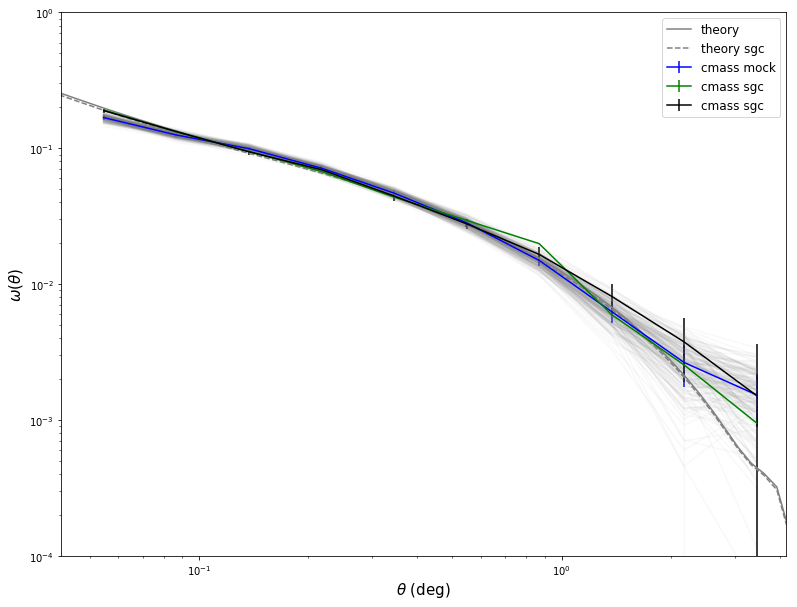

In [20]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/mocks//acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)

#
meanr, xi, xi_err = np.loadtxt('../data_txt/mocks//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))


for i in range(1,201):
    try:
        meanr, xi, xi_err = np.loadtxt('../data_txt/mocks_ran10//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_{:04}.txt'.format(i), unpack=True)
        ax.plot(meanr, xi, color='grey', alpha = 0.05)
    
    except (IOError, ValueError): pass
    
ax.errorbar(meanr, xi_list_mean, yerr = xi_list_sigma, fmt = '-', color='b', label='cmass mock')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='r', label='dmass vetoed')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='cmass sgc')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k-', color='r', label='cmass sgc')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)


In [22]:
xi_list_sigma

array([0.00580633, 0.00446376, 0.00351645, 0.00276759, 0.00223925,
       0.00199084, 0.00193024, 0.00166533, 0.00153357, 0.00128082])

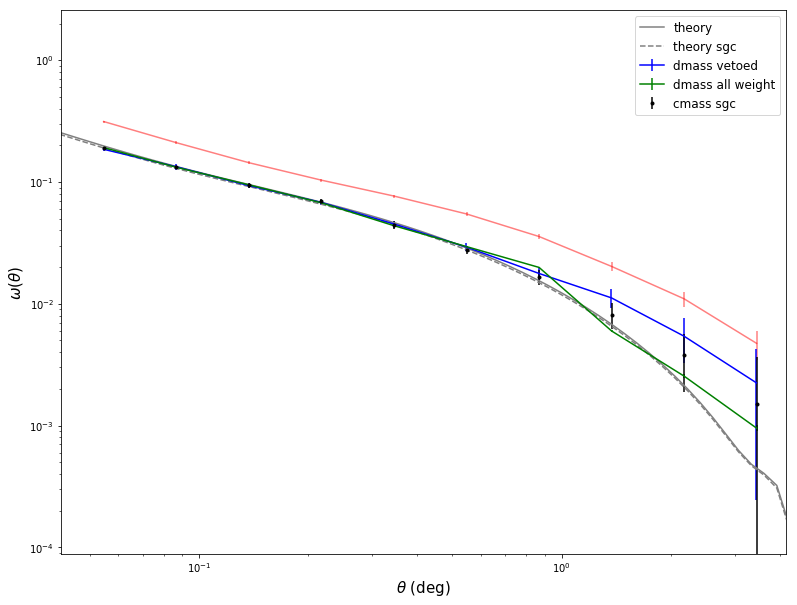

In [23]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/mocks//acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)

#
meanr, xi, xi_err = np.loadtxt('../data_txt/mocks//acf_auto_poisson_Patchy-Mocks-DR12CMASS-S-V6C-Portsmouth-mass_0001.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))

ax.errorbar(meanr, xi_list_mean, yerr = xi_list_sigma, fmt = '-', color='r', alpha = 0.5)
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='dmass vetoed')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='dmass all weight')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k.', color='r', label='cmass sgc')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

